## ** ->> SARCASM <<- **

In [81]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Train model on historic Reddit posts**

In [82]:
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/Fake_and_True.csv'
PATH_TO_DATA =  '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/train-balanced-sarcasm.csv' # '../input/sarcasm/train-balanced-sarcasm.csv'  train-balanced-sarcasm.csv
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/tweet.csv'

# **Set up Environment**

In [83]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from matplotlib import pyplot as plt

# **Preprocess**

1.   There are 1 million comments from reddit in the full dataset
2.   For the time limit of the presentation the rows read from redit are limited to 5000



In [84]:
train_df = pd.read_csv(PATH_TO_DATA, nrows=5000)  # reduced from 10000 to stay within time limit for demonstration

In [85]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


**Check data and feature length**

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           5000 non-null   int64 
 1   comment         4999 non-null   object
 2   author          5000 non-null   object
 3   subreddit       5000 non-null   object
 4   score           5000 non-null   int64 
 5   ups             5000 non-null   int64 
 6   downs           5000 non-null   int64 
 7   date            5000 non-null   object
 8   created_utc     5000 non-null   object
 9   parent_comment  5000 non-null   object
dtypes: int64(4), object(6)
memory usage: 390.8+ KB


**Drop null rows**

In [87]:
train_df.dropna(subset=['comment'], inplace=True)

**Check data balance**

In [88]:
train_df['label'].value_counts()

label
0    4056
1     943
Name: count, dtype: int64

**Split data into training, validation**

In [89]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=42)

# **Exploratory data analysis (EDA)**

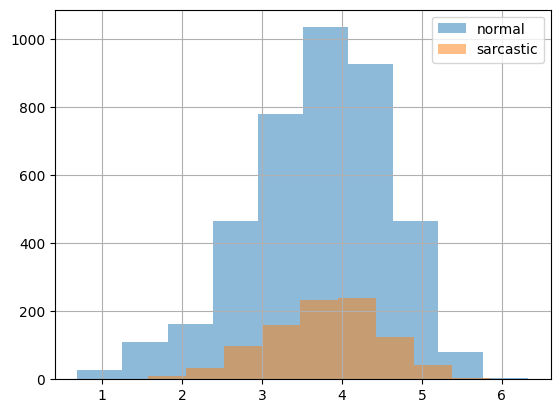

In [90]:
# histograph of sarcastic vs normal

train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
plt.legend();

# **Visualisations Word Clouds**

In [91]:
# wordcloud

from wordcloud import WordCloud, STOPWORDS

In [92]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100,
                random_state = 17, width=800, height=400)

# **Analysis of Data**

**All reddit comments of any size**

In [93]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
sub_df.sort_values(by='sum', ascending=False).head(10)

<ipython-input-93-57c392d54f67>:1: FutureWarning: The provided callable <function mean at 0x7f0734ba7d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-93-57c392d54f67>:1: FutureWarning: The provided callable <function sum at 0x7f0734ba6dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-93-57c392d54f67>:1: FutureWarning: The provided callable <function median at 0x7f0734553400> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be use

,size,mean,sum,median,std,min,max
subreddit,,,,,,,
politics,354,0.367232,130,0.0,0.482733,0,1
AskReddit,378,0.134921,51,0.0,0.342092,0,1
The_Donald,177,0.158192,28,0.0,0.365956,0,1
leagueoflegends,71,0.281690,20,0.0,0.453025,0,1
pcmasterrace,81,0.234568,19,0.0,0.426369,0,1
nfl,92,0.184783,17,0.0,0.390248,0,1
worldnews,81,0.209877,17,0.0,0.409758,0,1
pics,45,0.333333,15,0.0,0.476731,0,1
news,56,0.250000,14,0.0,0.436931,0,1


**Only reddit comment data greater than 1,000**

In [94]:
sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)
#sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum,median,std,min,max
subreddit,,,,,,,
politics,354,0.367232,130,0.0,0.482733,0,1
The_Donald,177,0.158192,28,0.0,0.365956,0,1
AskReddit,378,0.134921,51,0.0,0.342092,0,1


**Reddit comments grouped by Author and Size > 300**

In [95]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)
#sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)

<ipython-input-95-6fa4fda07e11>:1: FutureWarning: The provided callable <function mean at 0x7f0734ba7d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-95-6fa4fda07e11>:1: FutureWarning: The provided callable <function sum at 0x7f0734ba6dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-95-6fa4fda07e11>:1: FutureWarning: The provided callable <function median at 0x7f0734553400> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used dire

,size,mean,sum,median,std,min,max
author,,,,,,,


**Reddit comments with score > 0 and character size > 300**

In [96]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)

<ipython-input-96-fbd3a83c61a7>:1: FutureWarning: The provided callable <function mean at 0x7f0734ba7d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-96-fbd3a83c61a7>:1: FutureWarning: The provided callable <function sum at 0x7f0734ba6dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum, np.median, np.std, np.min, np.max])
<ipython-input-96-fbd3a83c61a7>:1: FutureWarning: The provided callable <function median at 0x7f0734553400> is currently using SeriesGroupBy.median. In a future version of p

,size,mean,sum,median,std,min,max
score,,,,,,,
4,210,0.238095,50,0.0,0.426935,0,1
3,467,0.231263,108,0.0,0.422093,0,1
0,204,0.215686,44,0.0,0.412309,0,1
7,121,0.214876,26,0.0,0.412444,0,1
6,164,0.201220,33,0.0,0.402140,0,1
8,110,0.200000,22,0.0,0.401831,0,1
5,202,0.178218,36,0.0,0.383647,0,1
2,837,0.173238,145,0.0,0.378679,0,1
1,1756,0.158884,279,0.0,0.365672,0,1


**Reddit comments with score < 0 and character size > 300**

In [97]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum,  np.median, np.std, np.min, np.max])
sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)
#sub_df[sub_df['size'] > 100].sort_values(by='mean', ascending=False).head(10)

<ipython-input-97-caf1a2e93f42>:1: FutureWarning: The provided callable <function mean at 0x7f0734ba7d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum,  np.median, np.std, np.min, np.max])
<ipython-input-97-caf1a2e93f42>:1: FutureWarning: The provided callable <function sum at 0x7f0734ba6dd0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum,  np.median, np.std, np.min, np.max])
<ipython-input-97-caf1a2e93f42>:1: FutureWarning: The provided callable <function median at 0x7f0734553400> is currently using SeriesGroupBy.median. In a future version of p

,size,mean,sum,median,std,min,max
score,,,,,,,


# **Training the model**
Using a pipe line of
1.   TF-iDF standing ofr term frequency and inverse docuemnt frequency
2.   Logistic regression



In [98]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs',
                           random_state=42, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])

In [99]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


CPU times: user 226 ms, sys: 108 ms, total: 334 ms
Wall time: 1.92 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=42,
                                    verbose=1))])

In [100]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 30.1 ms, sys: 1e+03 µs, total: 31.1 ms
Wall time: 32.6 ms


In [65]:
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/Fake_and_True.csv'
#valid_texts = pd.read_csv(PATH_TO_DATA) # , nrows=5500)
# valid_texts = valid_texts['text']
# y_valid = valid_texts['label']

In [101]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 32.8 ms, sys: 980 µs, total: 33.8 ms
Wall time: 34 ms


# **Reference base line Saracasm accuracy**

In [102]:
accuracy_value = accuracy_score(y_valid, valid_pred)
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(y_valid, valid_pred, average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score(y_valid, valid_pred, average='macro')
print("Precison score = ", precision_score_value)

Accuracy score =  0.8208
F1_score =  0.471941219514035
Precison score =  0.6891395827737488


# **NEW Data**

Load Truth prediction dataset with...
1.   Truth prediction results from earlier Truth detector algorithm
2.   Original same pulled down X / Twitter tweets

In [103]:
# NEW SECTION

#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/tweet.csv'
PATH_TO_DATA = '/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv'

df_new_texts = pd.read_csv(PATH_TO_DATA, nrows=1000)
df_new_texts['clean_joined_text']

# train_texts, valid_texts, y_train, y_valid = \
#         train_test_split(tweet_df['comment'], train_df['label'], random_state=42)
# tfidf_logit_pipeline.fit(train_texts, y_train)


0      thank foxandfriends great timeline failures ob...
1      person suggest rig america elections evidence ...
2      president obama quote election thought crooked...
3      republicans leading generic poll popular tax c...
4      matt schlapp cpac getting ready exciting event...
                             ...                        
995    congratulations andres manuel lopez obrador pr...
996    today great honor welcome prime minister mark ...
997    democrats deeply concerned fact leadership wan...
998    crazy maxine waters said corrupt people politi...
999    interviewed impressive people yesterday monday...
Name: clean_joined_text, Length: 1000, dtype: object

# **Predict Sarcasm with Logistic regression based on new X(twitter) texts**

In [105]:
#ORIGINAL predicted_value = tfidf_logit_pipeline.predict(df_new_texts['Text'])

predicted_value = tfidf_logit_pipeline.predict(df_new_texts['content'].values.astype('U'))

In [106]:
# NEW SECTION

df_new_texts['predicted_sarcasm'] = 0

for i in range(len(predicted_value)):
  if predicted_value[i] == 1:
    df_new_texts.loc[i, ('predicted_sarcasm')] = 1
  # elif predicted_value.iloc[i] == 0:
  #   df_new['Fake'] = 0

print(df_new_texts['predicted_sarcasm'])

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: predicted_sarcasm, Length: 1000, dtype: int64


In [71]:
# assumed the same as trained model # accuracy_score(y_valid, valid_pred)

# **Confusion Matrix**

In [107]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

# **Sarcasm - Confusion Matrix**

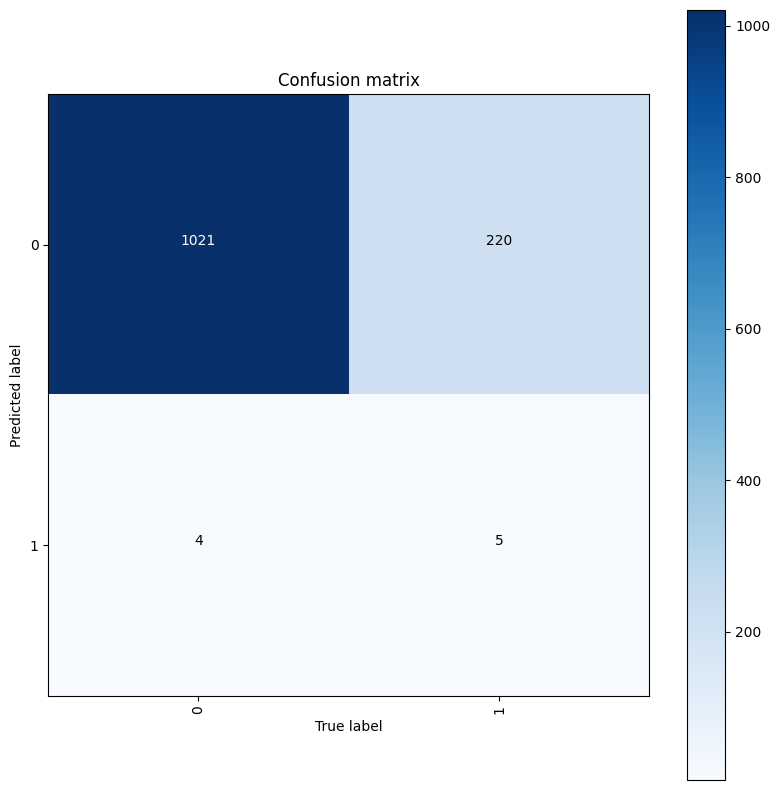

In [73]:
plot_confusion_matrix(y_valid, valid_pred,
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

# ** Model used to label X(twitter) label values to train, test split on them and doing an accuracy score**

# **Sample graphic to represent prediction of Sarcasm or Not/Straight Talk**

<ipython-input-108-9e2db9c6fb92>:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5


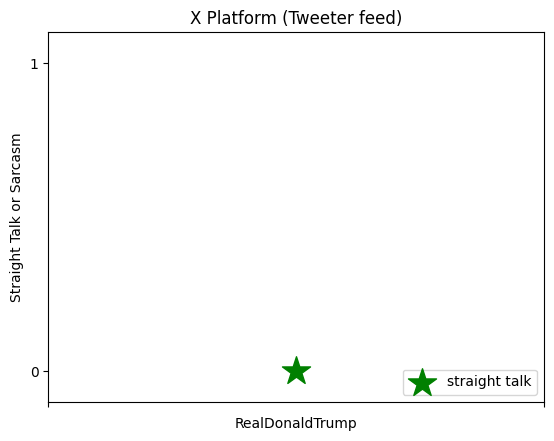

In [108]:
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA # - originally form Truth Fake module

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
y = df_new_texts['predicted_sarcasm'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]


if y == 1:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry talk", color= "red",
            marker= "X", s=450)
  plt.legend(loc='upper right')

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "straight talk", color= "green",
            marker= "*", s=450)
  plt.legend(loc='lower right')


# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Straight Talk or Sarcasm')
# plot title
plt.title('X Platform (Tweeter feed)')
# showing legend
#plt.legend()
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])

# function to show the plot
plt.show()

# **Model Improvement** above tfidf+logit regression 70% accurate -> trying here LSTM to get higher accuracy

In [109]:
# LSTM

# Text pre-processing
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.callbacks import EarlyStopping
# # Modeling
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional


# #!pip install keras
# import keras.preprocessing.text Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Embedding, LSTM, Dense
# from keras.models import Sequential

import keras
#import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.models import Sequential


# train_texts, valid_texts, y_train, y_valid = \
#         train_test_split(train_df['comment'], train_df['label'], random_state=42)

# The input text, example could be list of sentences
texts = train_texts[:] # [...]

# The labels corresponding to the input text
labels = y_train[:] # train_df['label'] # train_texts['Author'] # [...]

# Hyperparameters
max_words = 10000 # max number of words to use in the vocabulary
max_len = 200 # max length of each text (in terms of number of words)
embedding_dim = 200 # dimension of word embeddings
lstm_units = 64 # number of units in the LSTM layer
num_classes = len(set(labels)) # 2 # len(y_train) # y_train.unique() # 2 # len(set(labels)) # number of classes

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts.values.astype('U'))
sequences = tokenizer.texts_to_sequences(texts.values.astype('U'))

# Pad the sequences so they all have the same length
x = pad_sequences(sequences, maxlen=max_len)

# Create one-hot encoded labels
y = keras.utils.to_categorical(labels,
                               num_classes)

# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax')) # 'relu'' ; "rmsprop"

# optimizer='adam', loss='mse'


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 'binary_crossentropy'

# train_texts, valid_texts, y_train, y_valid

# Train the model
model.fit(x, y, batch_size=32, epochs=5)  # originally epochs=5 but reduced to 5 for time

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 279ms/step - accuracy: 0.8090 - loss: 0.5192
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 278ms/step - accuracy: 0.8302 - loss: 0.4013
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - accuracy: 0.9175 - loss: 0.2025
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.9747 - loss: 0.0769
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 290ms/step - accuracy: 0.9887 - loss: 0.0353


# **LSTM accuracy 90% to 100% depending on sample**

In [110]:
# write Sarcasm prediction results to shared dataframe

import numpy as np
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

#df_new_texts.drop()
#X = np.vectorize(df_new_texts['Text'])
#X = vec_train.transform(df_new_texts['clean_joined_text'])
#vec_train = CountVectorizer().fit(df_new_texts['clean_joined_text'].values.astype('U'))
#X = vec_train.transform(vec_train)
#X = df_new_texts['clean_joined_text']

# Required to run to remove 'predicted_sarcasm' rows
# df_new_texts.drop(index='predicted_sarcasm', axis=0, inplace=True)
# df_new_texts.drop(index='predicted_sarcasm', axis=0, inplace=True)

#X = np.vectorize(df_new_texts['clean_joined_text'].values.astype('U'))
# X = df_new_texts['clean_joined_text'].values.astype('U')
# #print(df_new_texts['clean_joined_text'].all)

texts = df_new_texts['content'] # ['clean_joined_text'] # TRY df_new_texts['Text']

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts.values.astype('U'))
sequences = tokenizer.texts_to_sequences(texts.values.astype('U'))

# Pad the sequences so they all have the same length
X = pad_sequences(sequences, maxlen=max_len)

# # Hyperparameters
# max_words = 10000 # max number of words to use in the vocabulary
# max_len = 200 # max length of each text (in terms of number of words)
# embedding_dim = 200 # dimension of word embeddings
# lstm_units = 64 # number of units in the LSTM layer
# num_classes = len(set(labels)) # 2 # len(y_train) # y_train.unique() # 2 # len(set(labels)) # number of classes


# # Build the model
# model = Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=max_len))
# model.add(LSTM(lstm_units), input_shape=(len(df_new_texts),2))
# model.add(Dense(num_classes, activation='softmax')) # 'relu'' ; "rmsprop"


# model.add(LSTM(22, input_shape=(360,1)))
# model.add(Dense(22, activation='softmax'))

prediction = []
prediction = model.predict(X)


# Creating multi-dimension array
#array1 = [1, 2, 4, [5, [6, 7]]]

# Object Data type is accept all data-type
Data_type = int

# Now we fix the error
#np_array = numpy.array(prediction, dtype=Data_type)
prediction = np.array(prediction, dtype=Data_type)
prediction = prediction.flatten('C') # 'C' means to flatten in a row-major style

# df_new_texts['predicted_sarcasm'] = 0
# for i in range(len(prediction)):
#   if prediction[i] >= 0.99:
#     #df_new_texts.loc['prediction', i] = int(prediction[i])
#     df_new_texts.loc[i, 'predicted_sarcasm'] = 1 # prediction[i]


df_new_texts['predicted_sarcasm'] = 0
for i in prediction:
  if i > 0.50:
    #df_new_texts.loc['prediction', i] = int(prediction[i])
    df_new_texts.loc[i, 'predicted_sarcasm'] = 1 # prediction[i]



print(df_new_texts)
#df_new_texts.predicted_sarcasm.sum()

df_new_texts = df_new_texts[['id', 'content', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm']].copy()

#df_new_texts.describe()

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
     Unnamed: 0                   id  \
0             0   965925223949357056   
1             1   965928352614965248   
2             2   965930611272712192   
3             3   965932714141650946   
4             4   965935035328155649   
..          ...                  ...   
995         995  1013618640061595648   
996         996  1013902140409040897   
997         997  1013976609290964997   
998         998  1014090584963866624   
999         999  1014092792329535488   

                                               content  \
0    Thank you to @ foxandfriends for the great tim...   
1    “There is no serious person out there who woul...   
2    ....The President Obama quote just before elec...   
3    Republicans are now leading the Generic Poll, ...   
4    Matt Schlapp and CPAC are getting ready for an...   
..                                                 ...   
995  Congratulations to Andres Manuel Lopez Obrador...   
996  Today, it

In [77]:
prediction.sum()

0

# **Scores**

1.   Full 1 million reddit data set results in 0.99 score for accuracy
2.   shortened for time limit of presentation scores 0.94 accuracy



In [111]:
# Scores

# try 'y_train' instead of train_df['label'] as is what is used in LSTM model
accuracy_value = accuracy_score(train_df.loc[:999, 'label'], df_new_texts.loc[ :998 ,'predicted_sarcasm'])  # try 'y_train' instead of train_df['label'] as is what is used in LSTM model
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(train_df.loc[:999, 'label'], df_new_texts.loc[ :998 ,'predicted_sarcasm'], average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score( train_df.loc[:999, 'label'], df_new_texts.loc[ :998 ,'predicted_sarcasm'], average='macro')
print("Precison score = ", precision_score_value)
recall_score_value = recall_score( train_df.loc[:999, 'label'], df_new_texts.loc[ :998 ,'predicted_sarcasm'], average='macro')
print("Recall score = ", precision_score_value)


Accuracy score =  0.93993993993994
F1_score =  0.4845201238390093
Precison score =  0.46996996996997
Recall score =  0.46996996996997


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Build up memory / previously in Truth-Fake detection notebook file and add new feature Sarcasm**

In [112]:
# save shared data frame with Saracasm prediction resutls added to the shared file

import csv

# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    reader = csv.reader(file)
    data = list(reader)

# Step 2: Define the values for the new column
new_values = df_new_texts['predicted_sarcasm'] # ['New York', 'Los Angeles', 'Chicago', 'San Francisco']

# Step 3: Add the new column header to the first row of the data
data[0].append('predicted_sarcasm')

# Step 4: Add the new column values to the remaining rows of the data
#for i in range(1, len(data)):
for i in range(1, len(new_values)):
    data[i].append(new_values[i - 1])

# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# **Sample graphic to represent prediction of Sarcasm or Not/Straight Talk**

<ipython-input-113-8b781ff982e6>:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-113-8b781ff982e6>:76: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5


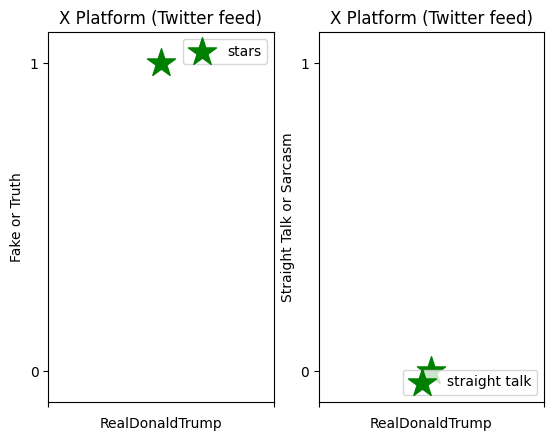

In [113]:
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA # - originally form Truth Fake module

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


plt.subplot(1, 2, 1)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
y = df_new_texts['predicted_true_fake'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]


if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry", color= "red",
            marker= "X", s=450)

if y == 1:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "stars", color= "green",
            marker= "*", s=450)


# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Fake or Truth')
# plot title
plt.title('X Platform (Twitter feed)')
# showing legend
plt.legend()
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])


plt.subplot(1, 2, 2)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
#y = df_new_texts['target'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
#y = int(prediction[0]) # [2,4,5,7,6,8,9,11,12,12]
y = prediction[0] # [2,4,5,7,6,8,9,11,12,12]

if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry talk", color= "red",
            marker= "X", s=450)
  plt.legend(loc='upper right')

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "straight talk", color= "green",
            marker= "*", s=450)
  plt.legend(loc='lower right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Straight Talk or Sarcasm')
# plot title
plt.title('X Platform (Twitter feed)')
# showing legend
#plt.legend()
#plt.legend(['Legend'], loc='upper left')
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])

# function to show the plot
#plt.show()

# function to show the plot
plt.show()